In [3]:
library(tidyverse)
ggplot2::theme_set(theme_bw())
library(ISLR)
library(leaps)

In [6]:
Hitters <- na.omit(Hitters)
dim(Hitters)

[1] 263  20

In [7]:
regfit.full <- regsubsets(Salary ~ ., Hitters, nvmax = 19)

In [ ]:
res <- regfit.full %>% summary # 변수 개수별 선택 변수
res$rsq # 모형별 R-Squared
res$bic # 모형별 bic값

[1] 11

[1] 10

[1] 6

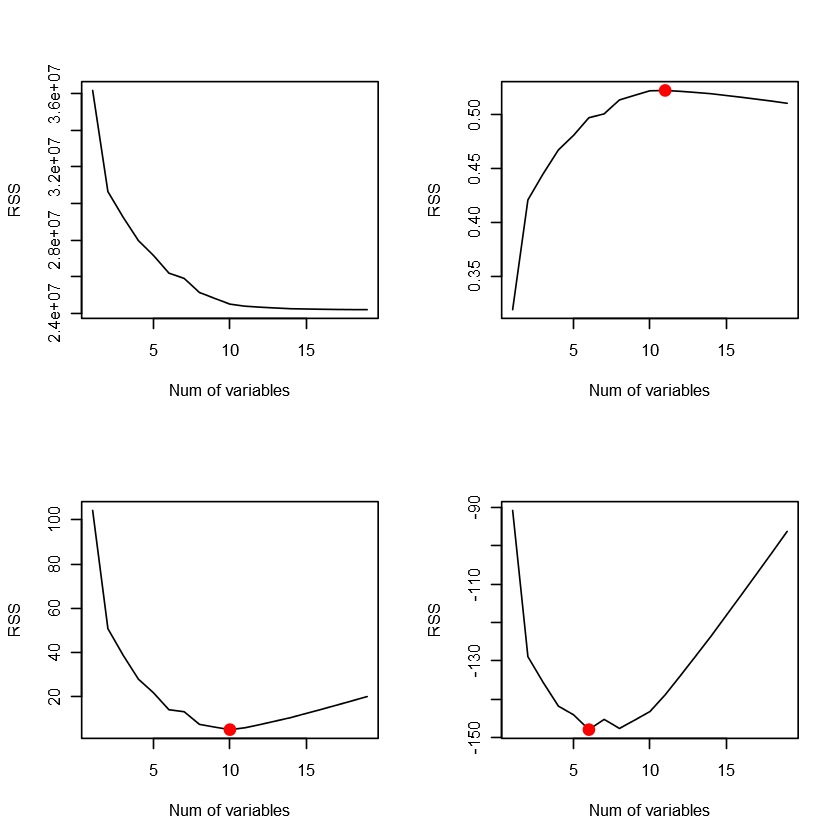

In [24]:
par(mfrow = c(2, 2))
plot(res$rss, xlab = "Num of variables", ylab = "RSS", type='l')
plot(res$adjr2, xlab = "Num of variables", ylab = "RSS", type='l')
which.max(res$adjr2)
points(11, res$adjr2[11], col="red", cex=2, pch=20)

plot(res$cp, xlab = "Num of variables", ylab = "RSS", type='l')
which.min(res$cp)
points(10, res$cp[10], col="red", cex=2, pch=20)

plot(res$bic, xlab = "Num of variables", ylab = "RSS", type='l')
which.min(res$bic)
points(6, res$bic[6], col="red", cex=2, pch=20)
par(mfrow = c(1, 11))

### 전진 후진 선택법

In [28]:
regfit.fwd <- regsubsets(Salary ~., Hitters, nvmax = 19, 
                         method = "forward")

regfit.bwd <- regsubsets(Salary ~., Hitters, nvmax = 19,
                         method = "backward")

- 변수 7개를 선택했을때의 모형

In [29]:
coef(regfit.full, 7)
coef(regfit.fwd, 7)
coef(regfit.bwd, 7)

(Intercept)         Hits        Walks       CAtBat        CHits       CHmRun 
  79.4509472    1.2833513    3.2274264   -0.3752350    1.4957073    1.4420538 
   DivisionW      PutOuts 
-129.9866432    0.2366813

(Intercept)        AtBat         Hits        Walks         CRBI       CWalks 
 109.7873062   -1.9588851    7.4498772    4.9131401    0.8537622   -0.3053070 
   DivisionW      PutOuts 
-127.1223928    0.2533404

(Intercept)        AtBat         Hits        Walks        CRuns       CWalks 
 105.6487488   -1.9762838    6.7574914    6.0558691    1.1293095   -0.7163346 
   DivisionW      PutOuts 
-116.1692169    0.3028847

### 모형 선택법

In [59]:
set.seed(1234)
train <- sort(sample(1:nrow(Hitters), 132))
test <- setdiff(1:nrow(Hitters), train)

In [60]:
regfit.best <- regsubsets(Salary ~., Hitters[train,], nvmax = 19)

In [61]:
test.mat <- model.matrix(Salary ~., Hitters[test,])
dim(test.mat)
val.error <- rep(NA, 19)

[1] 131  20

In [62]:
for (i in 1:19) {
  coefi <- coef(regfit.best, id = i)
  pred <- test.mat[, names(coefi)] %*% coefi
  val.error[i] <- mean((Hitters$Salary[test] - pred)^2)
}
which.min(val.error)

[1] 8

In [64]:
regfit.best <- regsubsets(Salary ~., Hitters, nvmax = 19)
coef(regfit.best, id = 8)

(Intercept)        AtBat         Hits        Walks       CHmRun        CRuns 
 130.9691577   -2.1731903    7.3582935    6.0037597    1.2339718    0.9651349 
      CWalks    DivisionW      PutOuts 
  -0.8323788 -117.9657795    0.2908431

### K-fold 모형 선택

In [65]:
k <- 10
set.seed(1234)
folds <- sample(1:k, nrow(Hitters), replace = T)
table(folds)

folds
 1  2  3  4  5  6  7  8  9 10 
19 22 31 29 28 39 19 26 25 25 

In [81]:
cv.errors <- matrix(NA, k, 19, dimnames = list(NULL, paste(1:19)))
cv.errors %>% print

       1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 [1,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [2,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [3,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [4,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [5,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [6,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [7,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [8,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
 [9,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[10,] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA


In [82]:
for (j in 1:k) {
  best.fit <- regsubsets(Salary ~., data = Hitters[folds != j,], 
                         nvmax = 19)
  test.mat <- model.matrix(Salary ~., Hitters[folds == j,])
  for (i in 1:19) {
    coefi <- coef(best.fit, id = i)
    pred <- test.mat[, names(coefi)] %*% coefi
    cv.errors[j, i] <- mean((Hitters$Salary[folds ==j]-pred)^2)
    
  }
}

In [73]:
mean.cv.errors <- apply(cv.errors, 2, mean)
mean.cv.errors %>% print

       1        2        3        4        5        6        7        8 
152999.4 133250.0 144972.7 134470.4 138124.1 125080.0 127457.1 116856.4 
       9       10       11       12       13       14       15       16 
116396.7 115637.2 114837.5 118080.4 119524.8 120471.8 121257.8 121998.2 
      17       18       19 
121995.9 122084.2 122012.1 


In [79]:
# plot(mean.cv.errors, type = "b")
which.min(mean.cv.errors) 

11 
11

In [86]:
reg.best <- regsubsets(Salary ~., Hitters, nvmax = 19)
coef(regfit.best, id = 11)

(Intercept)        AtBat         Hits        Walks       CAtBat        CRuns 
 135.7512195   -2.1277482    6.9236994    5.6202755   -0.1389914    1.4553310 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
   0.7852528   -0.8228559   43.1116152 -111.1460252    0.2894087    0.2688277